# Physician Density Prediction Interval



The goal of this notebook is to compute the estimate of an interval in which a forecasted physician demand will fall, with a specified 95% probability of the prediction lying within the interval.

The Regression coefficients of the Physician density Prediction model are found here: https://bmchealthservres.biomedcentral.com/articles/10.1186/1472-6963-12-79/tables/3


- Intercept 
    - 5.014 (2.676, 7.351)
- Proportion under age 15 years
    - -0.128 (-0.154, -0.102)
- Life expectancy (years)
    - 0.034 (0.009, 0.059)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i2twbd7b because the default path (/home/jjayme/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Get Physician Density Data

In [2]:
df = pd.read_csv('~/cpt5/capstone/data/processed/2010-30_demand_forecast.csv')
#clean data
df = df.drop(columns='Unnamed: 0', axis=1)

In [3]:
df.head()

,year,Region,population,mortality_rate_100k,rGDP,proportion_under15,proportion_over60,life_expectancy,infant_death_rate_per100k,maternal_death_rate_per100k,population_density,WHO_PD,PD
0,2010,NCR,11855975,578.265389,3.053160e+09,28.981229,5.759915,71.019294,1841.755959,88.105727,19136.0,10,13.831397
1,2011,NCR,12056622,568.069554,3.237139e+09,28.597401,5.940837,71.259294,1821.869754,66.257200,19460.0,10,14.260810
2,2012,NCR,12257269,571.236527,3.553089e+09,28.225682,6.116051,71.499294,1838.911067,61.944825,19784.0,10,14.684904
3,2013,NCR,12457916,570.320081,3.890702e+09,27.865508,6.285823,71.739294,1818.360930,89.481418,20108.0,10,15.103724
4,2014,NCR,12658563,570.641355,4.215201e+09,27.516350,6.450403,71.979294,1787.799913,88.013481,20432.0,10,15.517322


In [4]:
df.columns

Index(['year', 'Region', 'population', 'mortality_rate_100k', 'rGDP',
       'proportion_under15', 'proportion_over60', 'life_expectancy',
       'infant_death_rate_per100k', 'maternal_death_rate_per100k',
       'population_density', 'WHO_PD', 'PD'],
      dtype='object')

# Compute the standard deviation

In [5]:
def get_std_devs(mu, lower_bound):
    std_lower = (mu - lower_bound)/1.96
    return std_lower

In [6]:
# compute standard deviation
stdL_intercept = get_std_devs(mu=5.014, lower_bound=2.676)                               
stdL_prop15 = get_std_devs(mu=-0.128, lower_bound=-0.154)
stdL_lifeExp = get_std_devs(mu=0.034,lower_bound=0.009)

In [7]:
df1 = df[['year', 'Region', 'proportion_under15', 'life_expectancy', 'PD']]
df1.head()

,year,Region,proportion_under15,life_expectancy,PD
0,2010,NCR,28.981229,71.019294,13.831397
1,2011,NCR,28.597401,71.259294,14.260810
2,2012,NCR,28.225682,71.499294,14.684904
3,2013,NCR,27.865508,71.739294,15.103724
4,2014,NCR,27.516350,71.979294,15.517322


# Implement Monte-Carlo Simulations

In [24]:
def simulate_realizations(df, region, year, n):
    """Return physician densities from N Monte carlo simulations."""
    
    df_ = df[(df['Region'] == region) & (df['year']==year)]
    prop15 = df_['proportion_under15'].values[0]
    lifeExp = df_['life_expectancy'].values[0]
    
    PD_values = []
    coef_i = []
    coef_prop = []
    coef_life = []
    
    for i in range(n):
        coef_intercept = np.random.normal(loc=5.014 ,scale=stdL_intercept)
        coef_prop15 = np.random.normal(loc=-0.128,scale=stdL_prop15)
        coef_lifeExp = np.random.normal(loc=0.034,scale=stdL_lifeExp)
        
        PD = (coef_intercept + (coef_prop15*prop15) + (coef_lifeExp*lifeExp))**2
        PD_values.append(PD)
        coef_i.append(coef_intercept)
        coef_prop.append(coef_prop15)
        coef_life.append(coef_lifeExp)
    return PD_values,

def concatenated_df(df, n=10):
    """Return the concatenated dataframes."""
    
    df_all = pd.DataFrame()
    df_all['year'] = np.nan
    df_all['Region'] = np.nan

    for year in df.year.unique():
        for region in df.Region.unique():
            df_dummy = pd.DataFrame()
            df_dummy['year'] = [year]
            df_dummy['Region'] = [region]
            df_dummy['PD_values'] = [simulate_realizations(df, region, year,
                                                           n)]
            df_all = pd.concat([df_all, df_dummy]).reset_index(drop=True)
    return df_all

In [25]:
# apply monte carlo simulation with 1000 realizations
df_new = concatenated_df(df1, n=1000)

In [27]:
# merge datasets 
df2 = df1.merge(df_new, on=['year', 'Region'])
df2.head()

In [30]:
# remove brackets from PD_values (Physician densities)
df2['PD_values'] = df2['PD_values'].apply(lambda x: list(x)[0])

# compute variance of PD for the 1000 realizations
df2['variance'] = df2['PD_values'].apply(lambda x: np.var(x))

# compute the mean physician density for the 1000 realizations
df2['mean_PD'] = df2['PD_values'].apply(lambda x: np.mean(x))

(array([257., 274., 197., 145.,  59.,  36.,  15.,  13.,   2.,   2.]),
 array([1.28143136e-03, 7.21118368e+00, 1.44210859e+01, 2.16309882e+01,
        2.88408904e+01, 3.60507927e+01, 4.32606949e+01, 5.04705971e+01,
        5.76804994e+01, 6.48904016e+01, 7.21003039e+01]),
 <BarContainer object of 10 artists>)

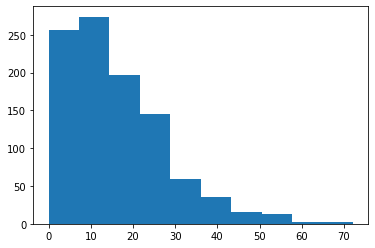

In [31]:
# plot histogram of Physician densities
plt.hist(df2.iloc[0]['PD_values'])

In [32]:
df2[['year', 'Region', 'PD', 'mean_PD', 'variance']]

,year,Region,PD,mean_PD,variance
0,2010,NCR,13.831397,16.021231,139.638365
1,2011,NCR,14.260810,17.153624,165.020275
2,2012,NCR,14.684904,16.500451,138.566240
3,2013,NCR,15.103724,17.736813,169.999958
4,2014,NCR,15.517322,18.262776,177.436715
...,...,...,...,...,...
352,2026,BARMM,6.850954,9.003922,73.180575
353,2027,BARMM,7.187704,9.818395,79.767773
354,2028,BARMM,7.518603,9.941210,89.550601
355,2029,BARMM,7.843745,10.399220,92.949894


## Compute 95% Prediction interval

*The histogram shows non-normal PD values. We applied Log transformation to construct non-normal data as “normal*

In [37]:
df2['var_logT'] = df2.apply(lambda x: np.log(1 + (x['variance']/(x['mean_PD']**2))), axis=1)

In [38]:
# compute confidence interval
df2['CI'] = df2.apply(lambda x: np.exp(1.96*x['var_logT']), axis=1)

In [39]:
# compute lower and upper bound
df2['lower_bound'] = df2.apply(lambda x: x['mean_PD']/x['CI'], axis=1)
df2['upper_bound'] = df2.apply(lambda x: x['mean_PD']*x['CI'], axis=1)

In [40]:
df2[df2['year'] > 2021][['year', 'Region', 'PD', 'lower_bound', 'upper_bound']]

,year,Region,PD,lower_bound,upper_bound
12,2022,NCR,17.416605,9.211317,40.282770
13,2023,NCR,17.632299,9.244218,42.770667
14,2024,NCR,17.850039,10.173694,42.218907
15,2025,NCR,18.068942,9.607795,43.567316
16,2026,NCR,18.770631,10.498116,42.104446
...,...,...,...,...,...
352,2026,BARMM,6.850954,2.551974,31.767809
353,2027,BARMM,7.187704,3.011752,32.008245
354,2028,BARMM,7.518603,2.807636,35.199600
355,2029,BARMM,7.843745,3.083067,35.076691


In [42]:
# save dataset
df2[df2['year'] > 2021][['year', 'Region', 'PD', 'lower_bound', 
                'upper_bound']].to_csv('~/cpt5/capstone/data/processed/'
                                       '95%_PD_prediction_interval.csv')

## Prettify table

In [43]:
df3 = df2[df2['year'] > 2021][['year', 'Region', 'PD', 'lower_bound', 'upper_bound']]

In [44]:
df3['PD_bounds'] = df3.apply(lambda x: str(x['PD']) +' ('
                                         + str(x['lower_bound'])
                                         + ', '
                                         + str(x['upper_bound'])
                                         + ')', axis=1)

In [45]:
sorter = ['NCR', 'CAR', 'I - Ilocos', 'II - Cagayan', 'III - C. Luzon',
       'IVA - Calabarzon', 'MIMAROPA', 'V - Bicol', 'VI - W. Visayas',
       'VII - C. Visayas', 'VIII - E. Visayas', 'IX - Zamboanga',
       'X - N. Mindanao', 'XI - Davao', 'XII - SOCCSKSARGEN',
       'XIII - Caraga', 'BARMM']

In [46]:
sorterIndex = dict(zip(sorter, range(len(sorter))))

# Generate a rank column that will be used to sort
# the dataframe numerically
df3['Rank'] = df3['Region'].map(sorterIndex)

In [48]:
df3[['year', 'Region', 'PD', 'lower_bound', 'upper_bound', 'PD_bounds']].to_csv('~/cpt5/capstone/data/processed/95%_PD_prediction_interval.csv')

In [49]:
df4 = df3.sort_values(by=['year', 'Rank'])[['year', 'Region', 'PD_bounds']]

In [50]:
df4.rename(columns={'PD_bounds': 'PD (95% Confidence Interval)'}, inplace=True)

In [51]:
df4

,year,Region,PD (95% Confidence Interval)
12,2022,NCR,"17.416604844380863 (9.21131719314916, 40.28276..."
33,2022,CAR,"13.819606610317893 (6.97940265314549, 36.27896..."
54,2022,I - Ilocos,"14.794555834618215 (7.720336349427994, 38.9141..."
75,2022,II - Cagayan,"14.078439022829537 (7.193159505889685, 37.9305..."
96,2022,III - C. Luzon,"16.30024869924933 (8.655276800724334, 38.90371..."
...,...,...,...
272,2030,X - N. Mindanao,"16.690596946782147 (8.544565167799377, 41.8626..."
293,2030,XI - Davao,"15.734746091433074 (7.756844997878723, 38.8174..."
314,2030,XII - SOCCSKSARGEN,"15.04064024985038 (7.91911343823882, 43.351193..."
335,2030,XIII - Caraga,"13.21022466388646 (6.2531029949167936, 38.8647..."


In [52]:
df4.to_csv('~/cpt5/capstone/data/processed/95%_PD_prediction_interval.csv')